In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import missingno as msno  # for missing value visualization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, GRU # Added GRU for alternate model
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier # Added for alternate model
from sklearn.metrics import accuracy_score, classification_report # Added for alternate model evaluation

In [65]:
# Load and preprocess
df = pd.read_csv('ENDGAME_with_dates1.csv')

In [66]:
# Set style for plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")  # This sets Seaborn styling

In [67]:
print("="*50)
print("1. BASIC DATA OVERVIEW (with Date column)")
print("="*50)
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and non-null counts:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe(include='all').T)

1. BASIC DATA OVERVIEW (with Date column)
Dataset shape: (40320, 12)

First 5 rows:
  Timestamp        Date Sensor_ID  Temperature   Humidity  Gas_Concentration  \
0  00:00:00  2025-06-01      S001    27.819474  65.763842         325.743421   
1  00:01:00  2025-06-01      S001    23.413349  53.931272         208.235298   
2  00:02:00  2025-06-01      S001    25.074832  52.413415         424.230070   
3  00:03:00  2025-06-01      S001    25.996470  46.467356         365.256786   
4  00:04:00  2025-06-01      S001    18.885974  52.749109         168.046536   

   Fire_Status Event_Type Alert_Level             Location_ID  \
0            0     normal         low  Rack-4-Sector-A-Room-3   
1            0     normal         low  Rack-4-Sector-A-Room-3   
2            0     normal         low  Rack-4-Sector-A-Room-3   
3            0     normal         low  Rack-4-Sector-A-Room-3   
4            0     normal         low  Rack-4-Sector-A-Room-3   

  Response_Actions               Incident_ID

In [68]:
# 1.1 Missing/Null Value Check
print("\nMissing/Null values in each column:")
print(df.isnull().sum())


Missing/Null values in each column:
Timestamp              0
Date                   0
Sensor_ID              0
Temperature          403
Humidity             403
Gas_Concentration    403
Fire_Status            0
Event_Type           403
Alert_Level          403
Location_ID            0
Response_Actions     403
Incident_ID            0
dtype: int64


In [69]:
# 1.2 Missing value percentage
missing_info = df.isnull().sum().to_frame(name='Missing Count')
missing_info['% Missing'] = (missing_info['Missing Count'] / len(df)) * 100
print("\nMissing Values Summary:")
print(missing_info)


Missing Values Summary:
                   Missing Count  % Missing
Timestamp                      0   0.000000
Date                           0   0.000000
Sensor_ID                      0   0.000000
Temperature                  403   0.999504
Humidity                     403   0.999504
Gas_Concentration            403   0.999504
Fire_Status                    0   0.000000
Event_Type                   403   0.999504
Alert_Level                  403   0.999504
Location_ID                    0   0.000000
Response_Actions             403   0.999504
Incident_ID                    0   0.000000


<Figure size 400x200 with 0 Axes>

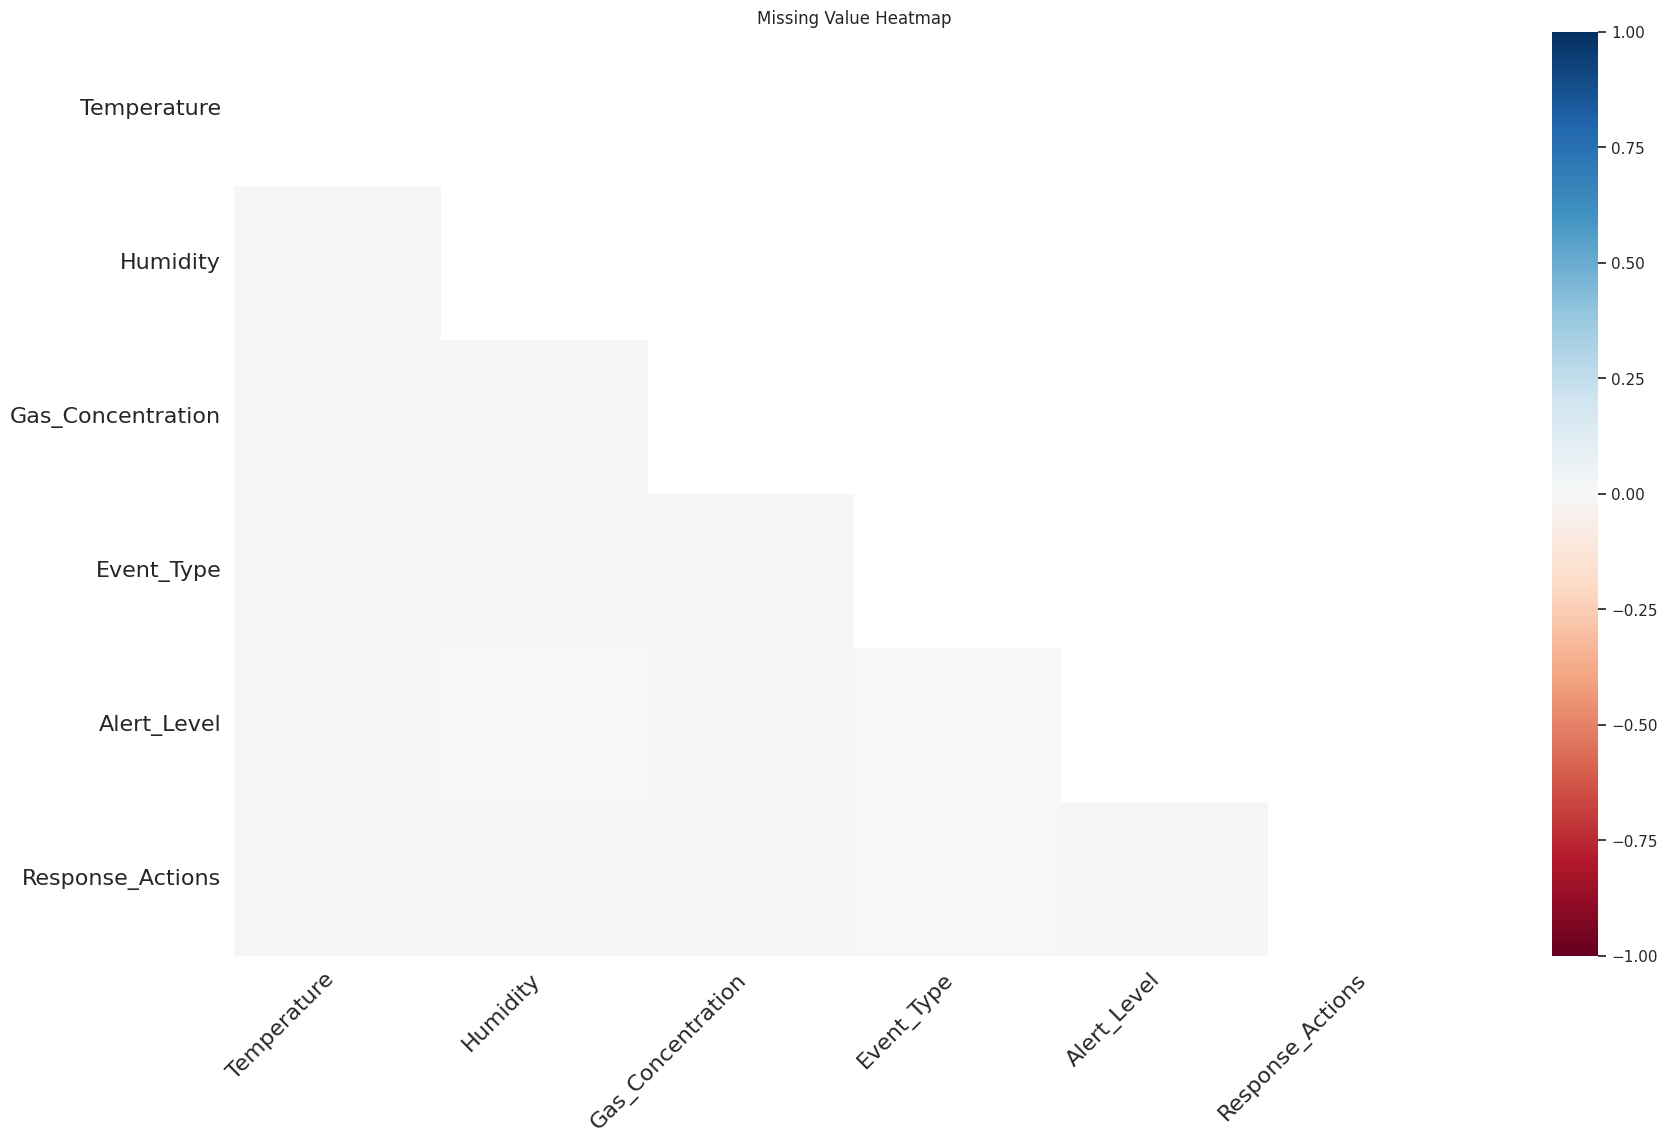

In [70]:
# Visualize missing values
plt.figure(figsize=(4, 2))
msno.heatmap(df)
plt.title("Missing Value Heatmap")
plt.show()

<Figure size 1000x500 with 0 Axes>

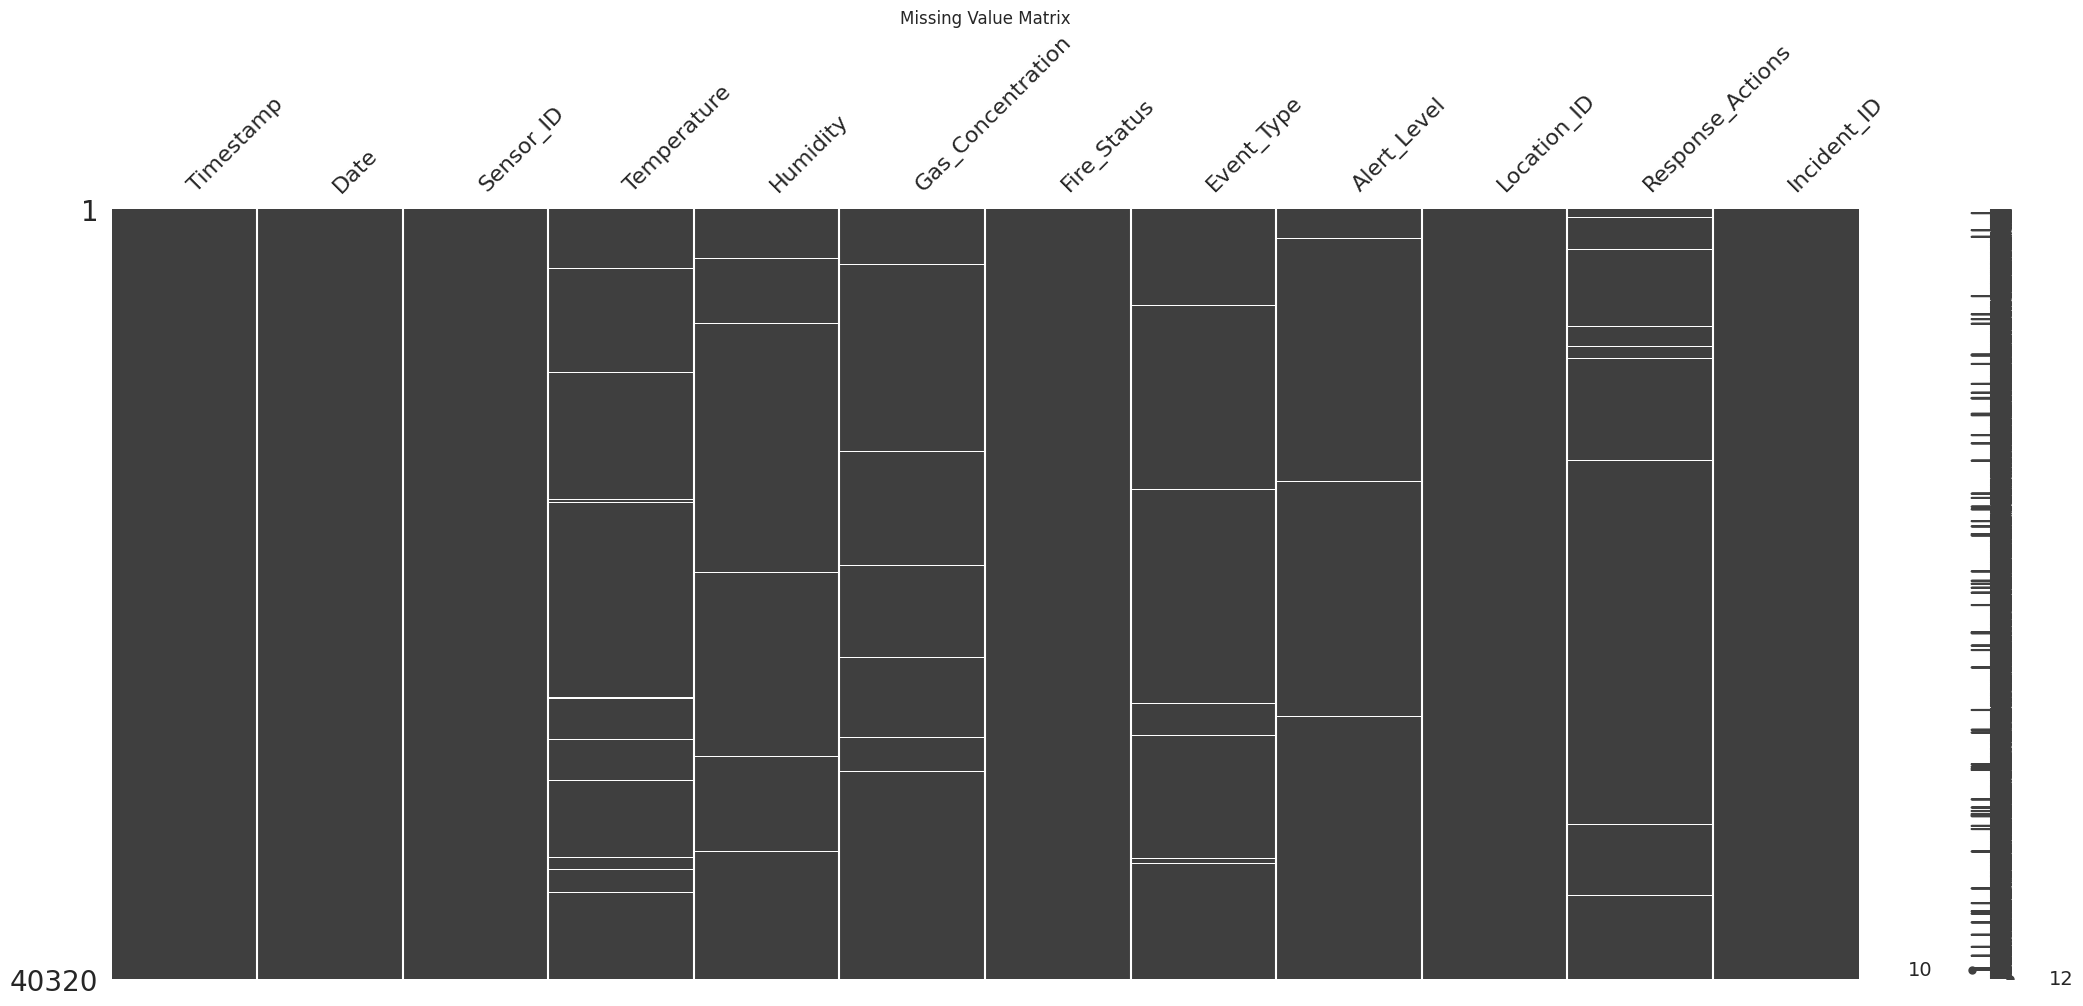

In [71]:
plt.figure(figsize=(10, 5))
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.show()


2. TIME ANALYSIS


<ipython-input-72-542853345>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])
<ipython-input-72-542853345>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('Timestamp')['Fire_Status'].resample('H').sum().plot(title='Fire Events Over Time (Hourly)')


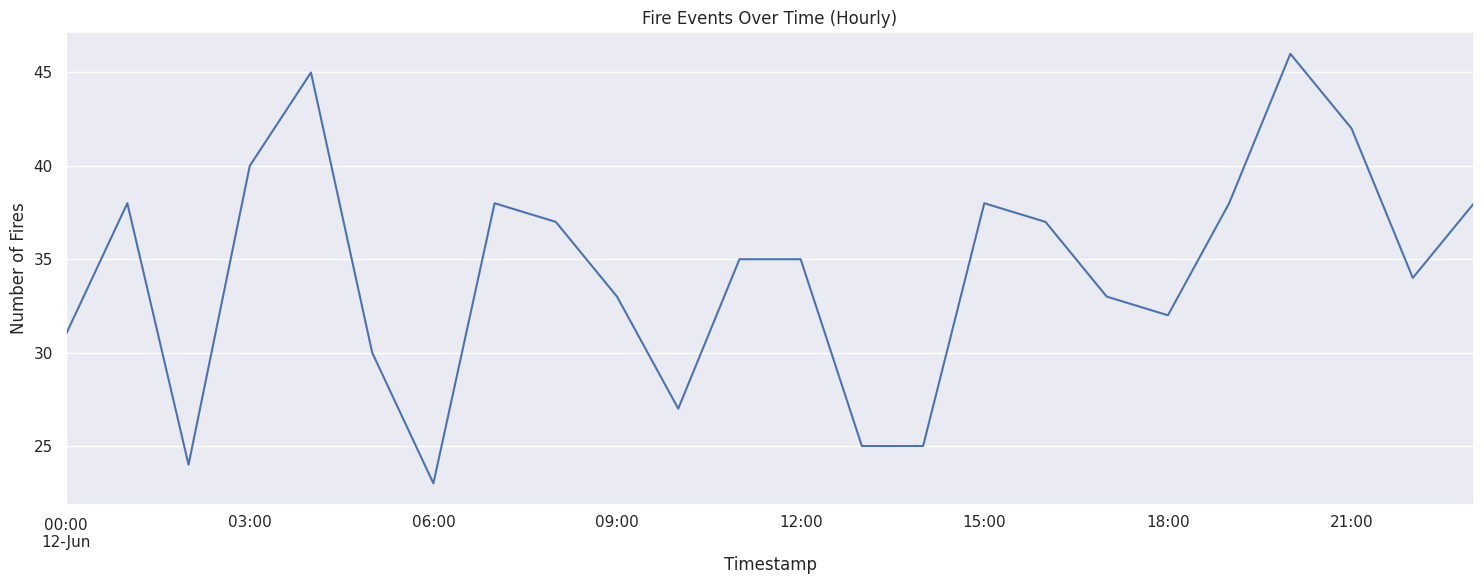

In [72]:
# 2. Time Analysis
print("\n" + "="*50)
print("2. TIME ANALYSIS")
print("="*50)

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

# Plot events over time
plt.figure(figsize=(15, 6))
df.set_index('Timestamp')['Fire_Status'].resample('H').sum().plot(title='Fire Events Over Time (Hourly)')
plt.ylabel('Number of Fires')
plt.tight_layout()
plt.show()


3. SENSOR AND LOCATION ANALYSIS

Unique Sensors: 4
Unique Locations: 4
Unique Event Types: 4
Unique Alert Levels: 3

Top 10 locations with most fire events:
Location_ID
Rack-3-Sector-C-Room-2    231
Rack-5-Sector-A-Room-1    206
Rack-2-Sector-B-Room-1    204
Rack-4-Sector-A-Room-3    183
Name: count, dtype: int64


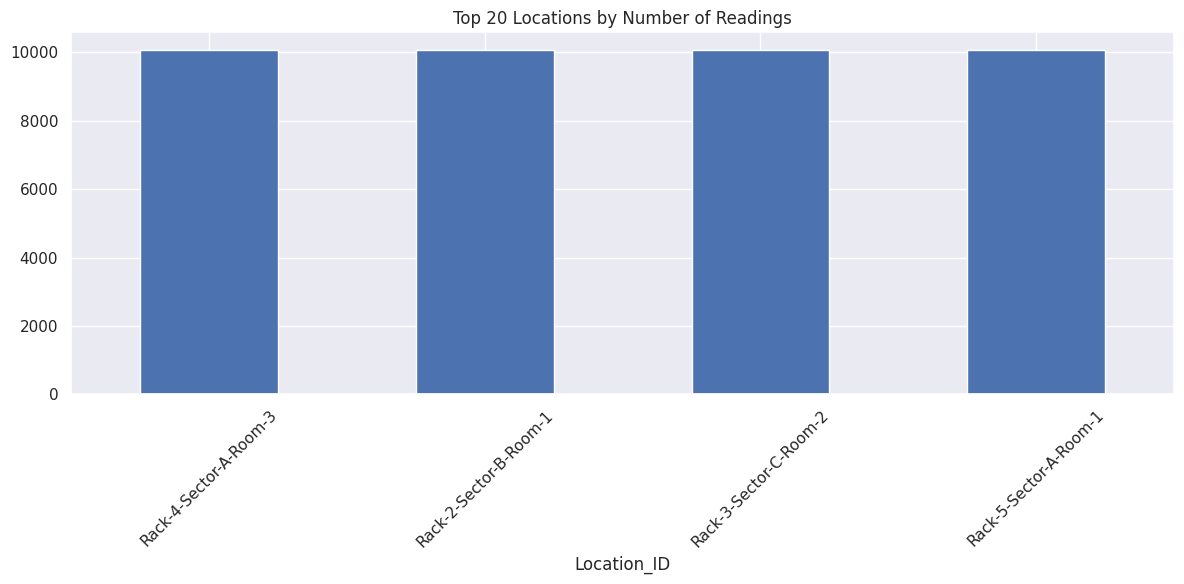

In [73]:
# 3. Sensor and Location Analysis
print("\n" + "="*50)
print("3. SENSOR AND LOCATION ANALYSIS")
print("="*50)
print(f"\nUnique Sensors: {df['Sensor_ID'].nunique()}")
print(f"Unique Locations: {df['Location_ID'].nunique()}")
print(f"Unique Event Types: {df['Event_Type'].nunique()}")
print(f"Unique Alert Levels: {df['Alert_Level'].nunique()}")

fire_locations = df[df['Fire_Status'] == 1]['Location_ID'].value_counts().head(10)
print("\nTop 10 locations with most fire events:")
print(fire_locations)

plt.figure(figsize=(12, 6))
df['Location_ID'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Locations by Number of Readings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


4. NUMERICAL FEATURES ANALYSIS


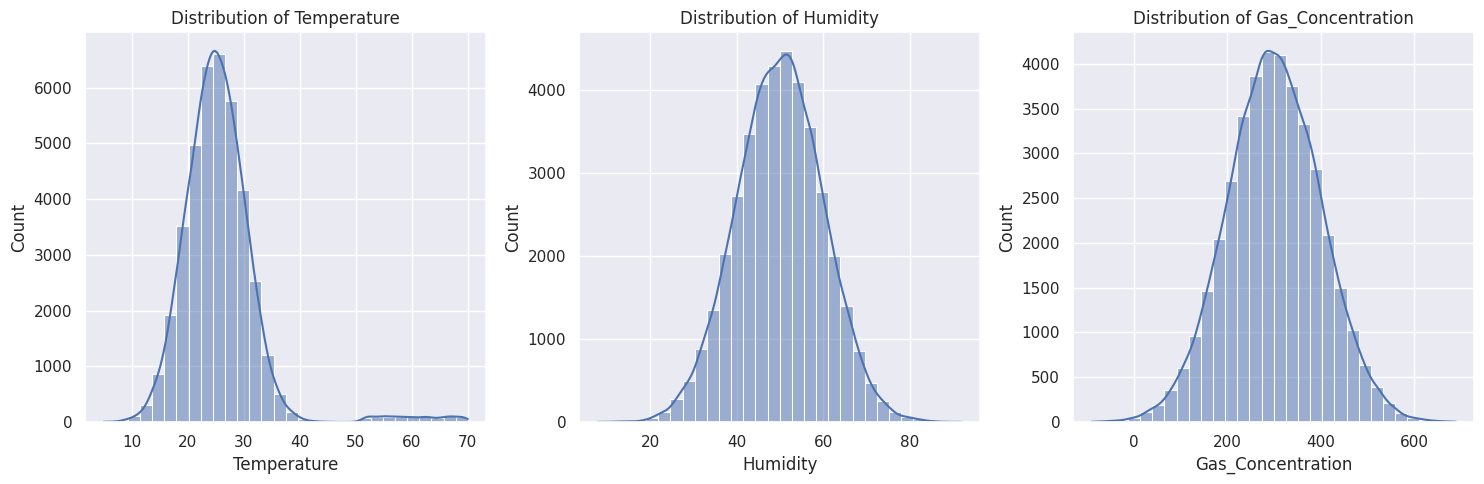

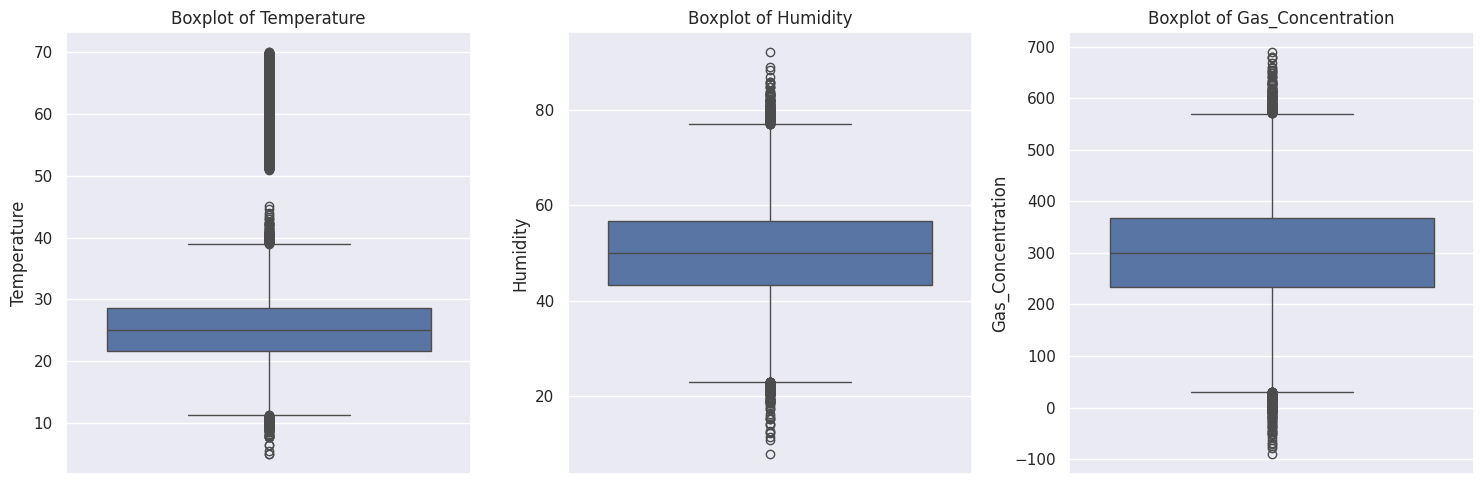

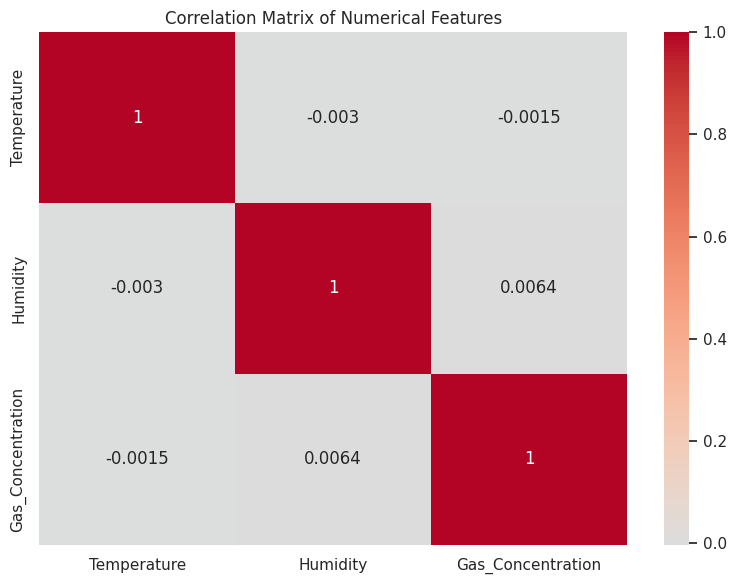

In [74]:
# 4. Numerical Features Analysis
print("\n" + "="*50)
print("4. NUMERICAL FEATURES ANALYSIS")
print("="*50)

num_cols = ['Temperature', 'Humidity', 'Gas_Concentration']

plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


5. CATEGORICAL FEATURES ANALYSIS


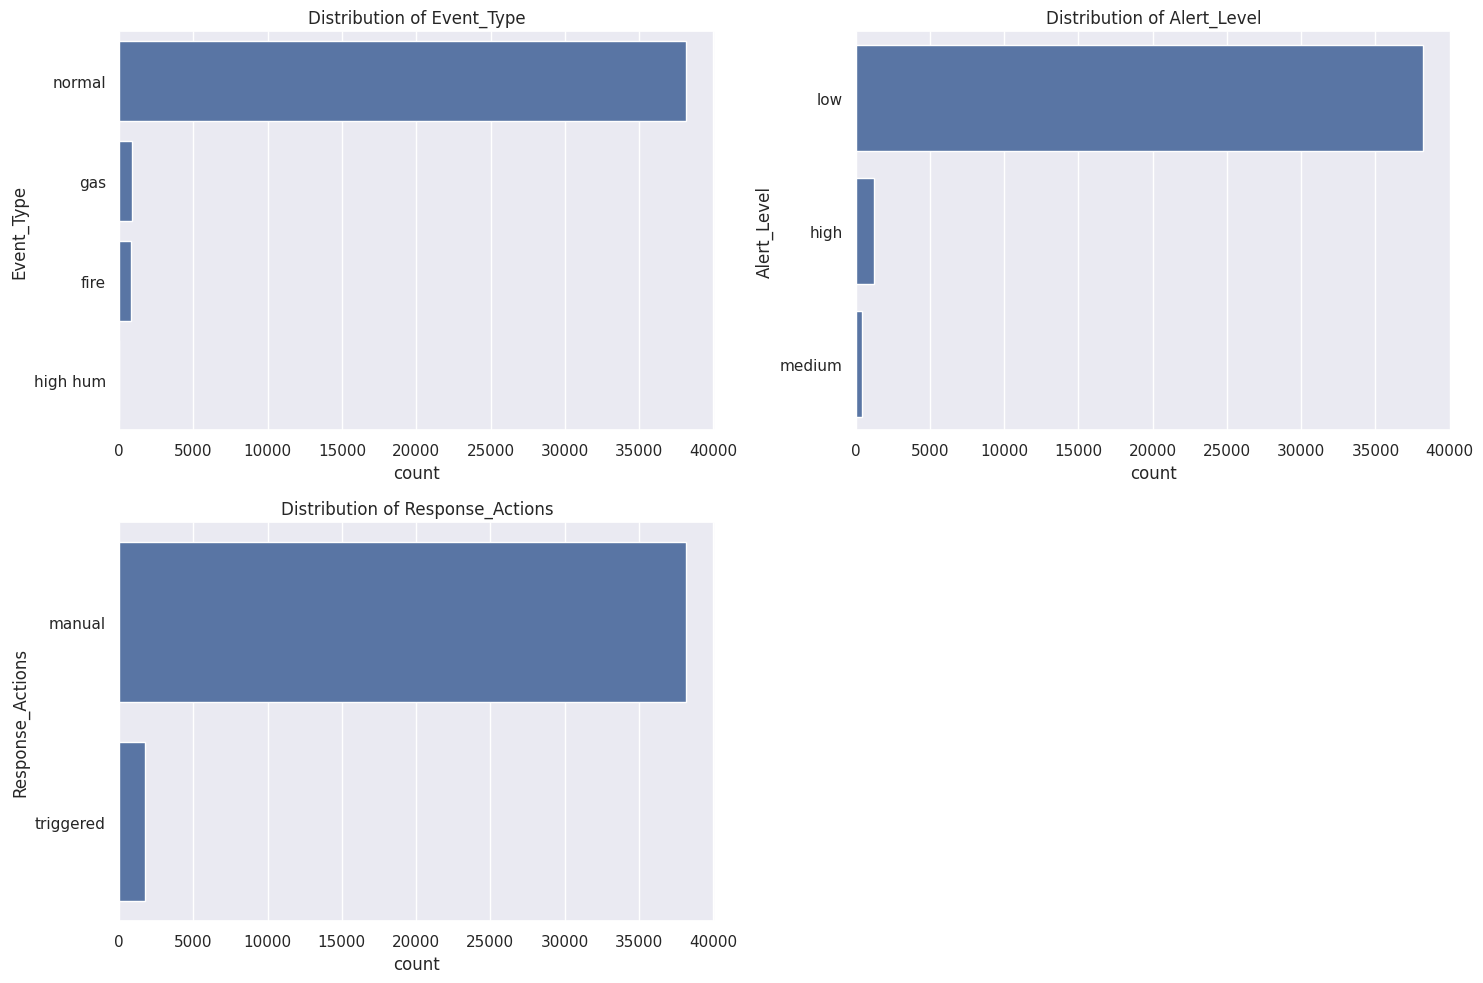

In [75]:
# 5. Categorical Features Analysis
print("\n" + "="*50)
print("5. CATEGORICAL FEATURES ANALYSIS")
print("="*50)

cat_cols = ['Event_Type', 'Alert_Level', 'Response_Actions']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


6. FIRE INCIDENT ANALYSIS

Fire Status Counts:
Fire_Status
0    39496
1      824
Name: count, dtype: int64


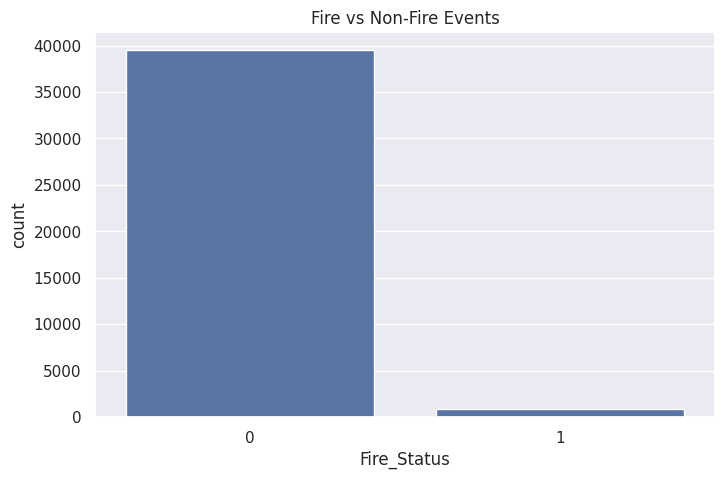

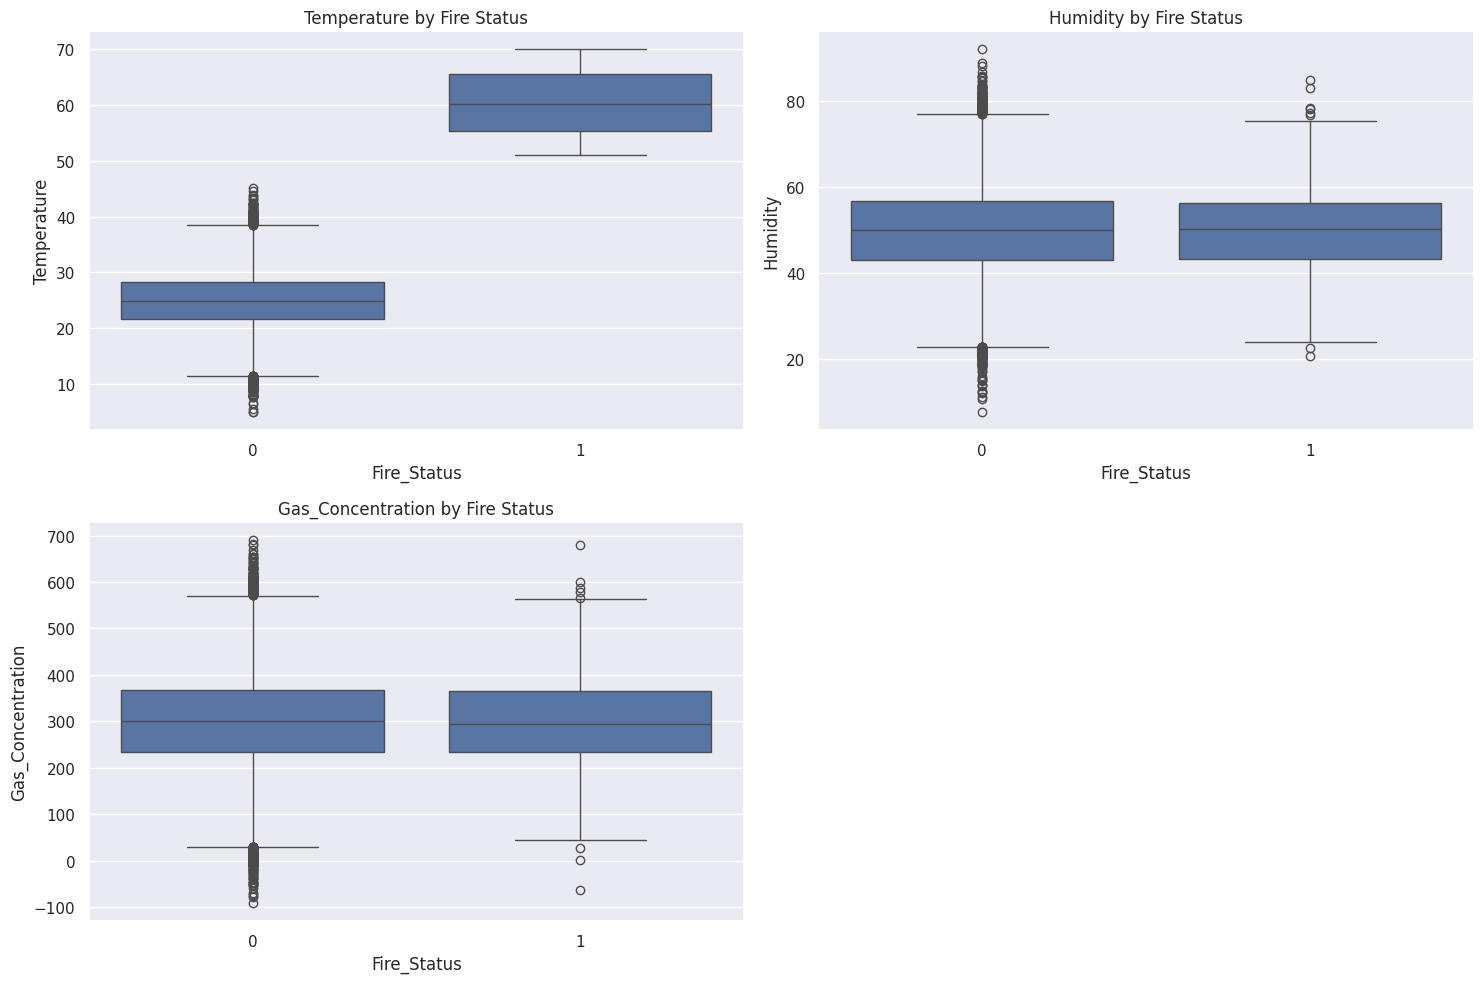


Event Types During Fires:
Event_Type
fire    819
Name: count, dtype: int64


In [76]:
# 6. Fire Incident Analysis
print("\n" + "="*50)
print("6. FIRE INCIDENT ANALYSIS")
print("="*50)

print("\nFire Status Counts:")
print(df['Fire_Status'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='Fire_Status', data=df)
plt.title('Fire vs Non-Fire Events')
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Fire_Status', y=col, data=df)
    plt.title(f'{col} by Fire Status')
plt.tight_layout()
plt.show()

fire_events = df[df['Fire_Status'] == 1]['Event_Type'].value_counts()
print("\nEvent Types During Fires:")
print(fire_events)


7. TEMPORAL PATTERNS


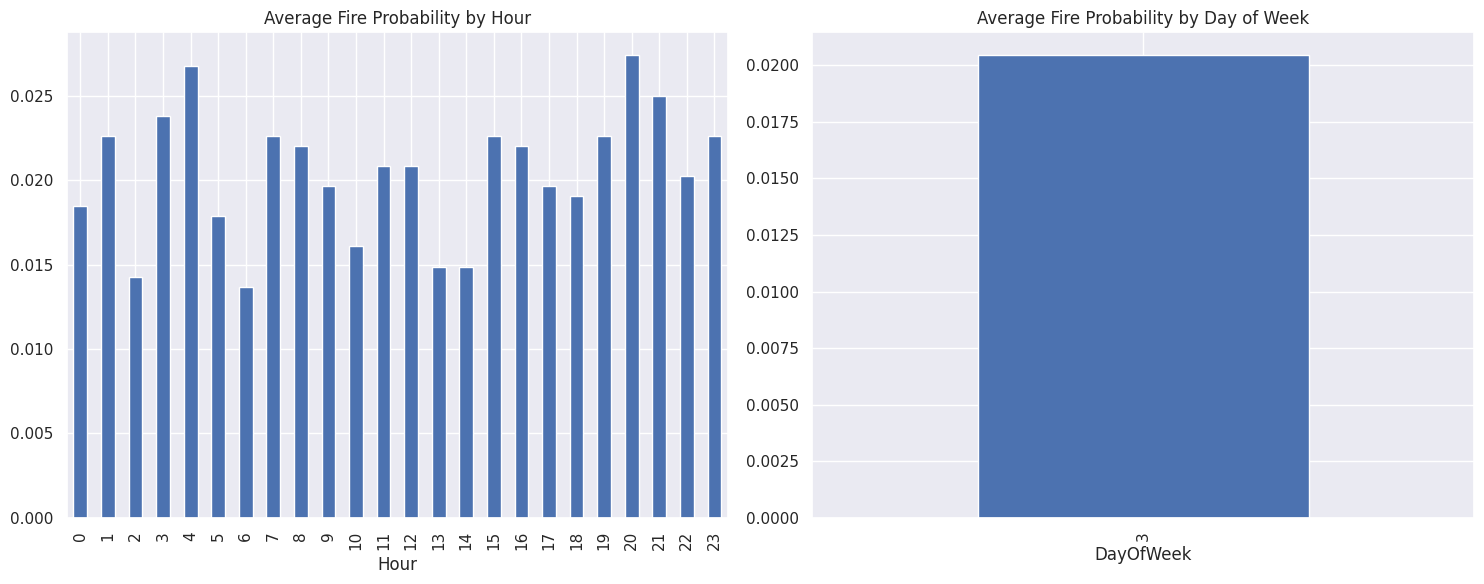

In [77]:
# 7. Temporal Patterns
print("\n" + "="*50)
print("7. TEMPORAL PATTERNS")
print("="*50)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
df.groupby('Hour')['Fire_Status'].mean().plot(kind='bar')
plt.title('Average Fire Probability by Hour')

plt.subplot(1, 2, 2)
df.groupby('DayOfWeek')['Fire_Status'].mean().plot(kind='bar')
plt.title('Average Fire Probability by Day of Week')
plt.tight_layout()
plt.show()


8. MULTIVARIATE ANALYSIS


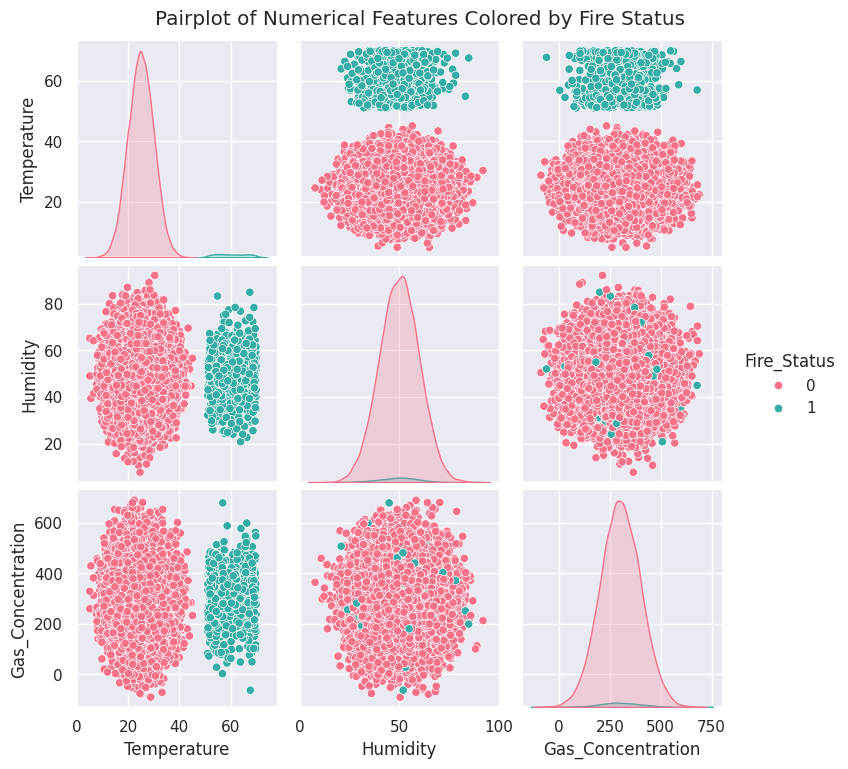

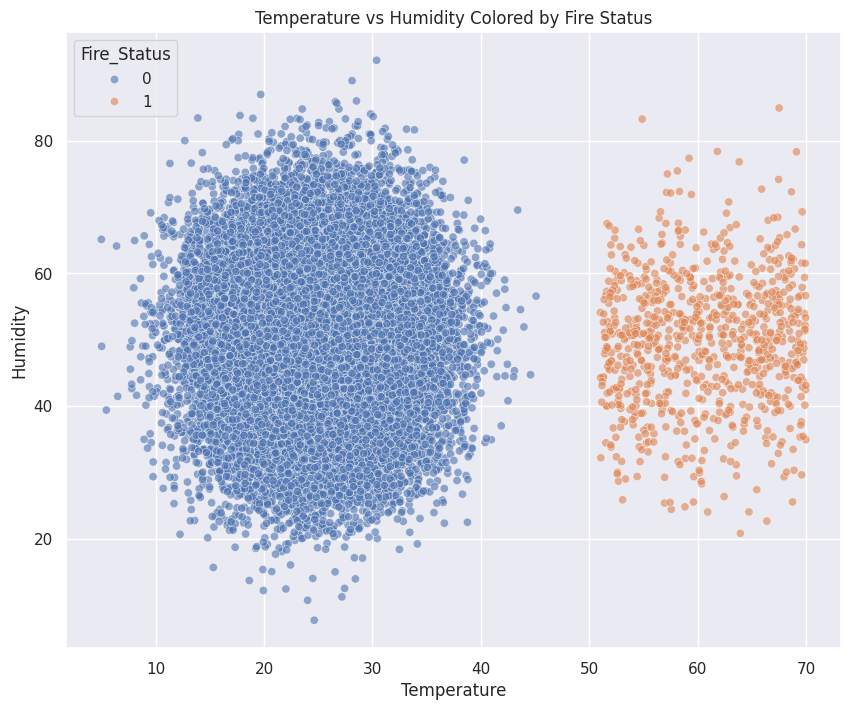

In [78]:
# 8. Multivariate Analysis
print("\n" + "="*50)
print("8. MULTIVARIATE ANALYSIS")
print("="*50)

sns.pairplot(df[num_cols + ['Fire_Status']], hue='Fire_Status', palette='husl')
plt.suptitle('Pairplot of Numerical Features Colored by Fire Status', y=1.02)
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Temperature', y='Humidity', hue='Fire_Status', data=df, alpha=0.6)
plt.title('Temperature vs Humidity Colored by Fire Status')
plt.show()


9. ALERT LEVEL ANALYSIS


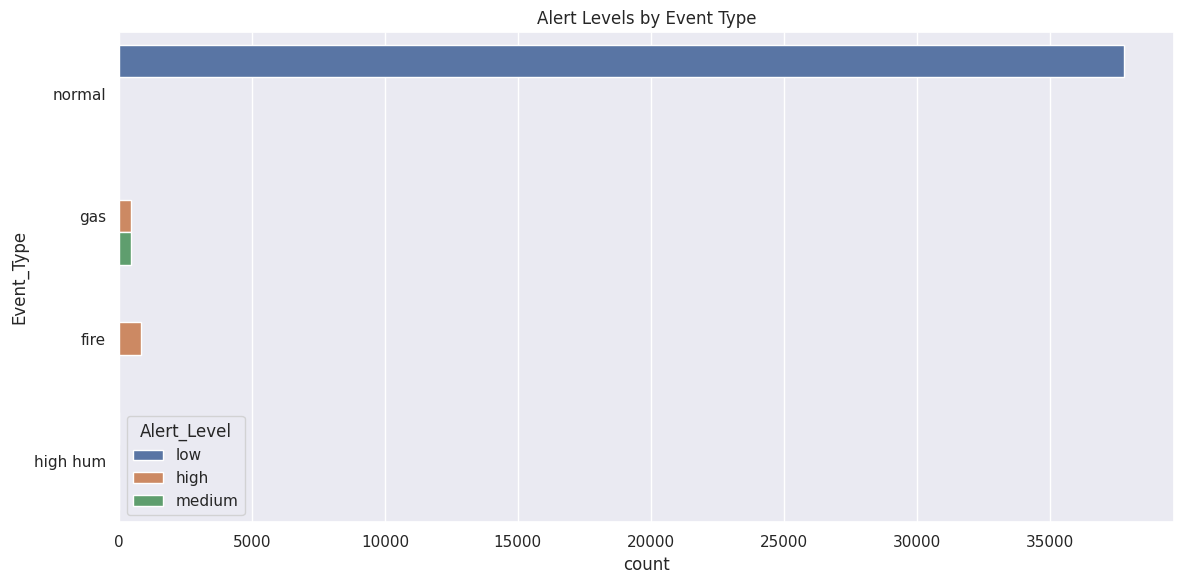

In [79]:
# 9. Alert Level Analysis
print("\n" + "="*50)
print("9. ALERT LEVEL ANALYSIS")
print("="*50)

plt.figure(figsize=(12, 6))
sns.countplot(y='Event_Type', hue='Alert_Level', data=df)
plt.title('Alert Levels by Event Type')
plt.tight_layout()
plt.show()


10. RESPONSE ACTIONS ANALYSIS

Response Actions During Fires:
Response_Actions
triggered    817
Name: count, dtype: int64


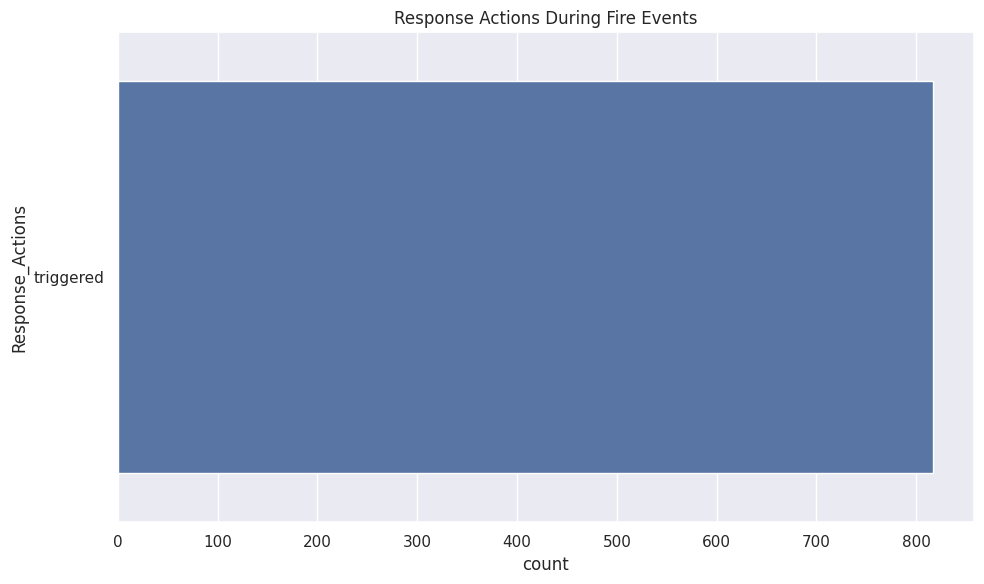

In [80]:
# 10. Response Actions Analysis
print("\n" + "="*50)
print("10. RESPONSE ACTIONS ANALYSIS")
print("="*50)

fire_responses = df[df['Fire_Status'] == 1]['Response_Actions'].value_counts()
print("\nResponse Actions During Fires:")
print(fire_responses)

plt.figure(figsize=(10, 6))
sns.countplot(y='Response_Actions', data=df[df['Fire_Status'] == 1])
plt.title('Response Actions During Fire Events')
plt.tight_layout()
plt.show()


11. LOCATION-SPECIFIC ANALYSIS


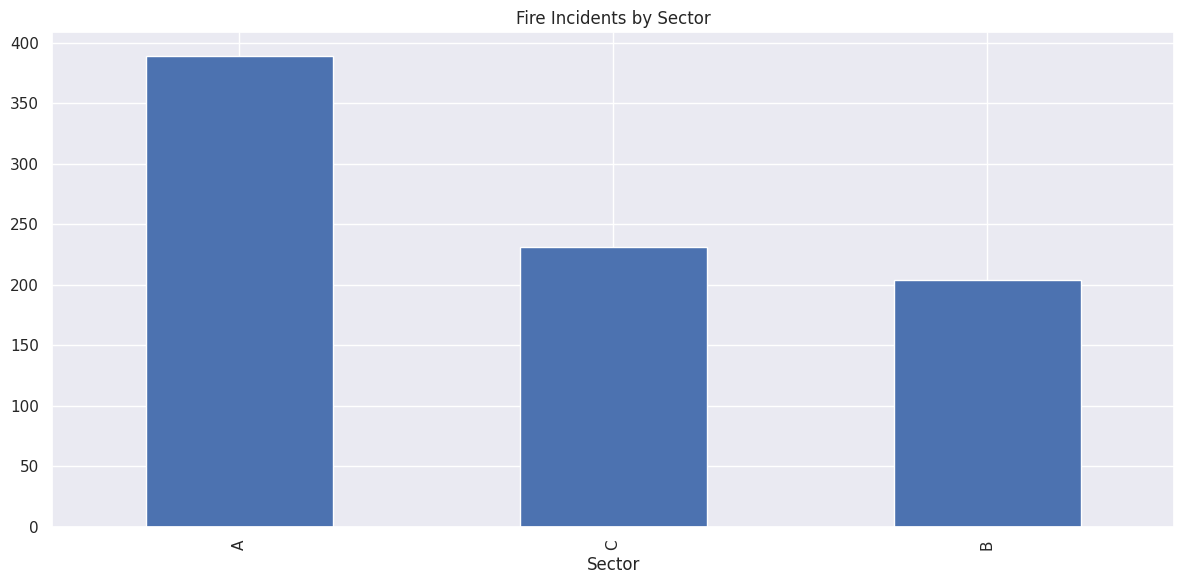

In [81]:
# 11. Location-Specific Analysis
print("\n" + "="*50)
print("11. LOCATION-SPECIFIC ANALYSIS")
print("="*50)

df['Sector'] = df['Location_ID'].str.extract(r'Sector-([A-Za-z0-9]+)')

plt.figure(figsize=(12, 6))
df[df['Fire_Status'] == 1]['Sector'].value_counts().plot(kind='bar')
plt.title('Fire Incidents by Sector')
plt.tight_layout()
plt.show()


12. SENSOR PERFORMANCE ANALYSIS

Top 10 Sensors with Most Fire Detections:
Sensor_ID
S003    231
S004    206
S002    204
S001    183
Name: count, dtype: int64


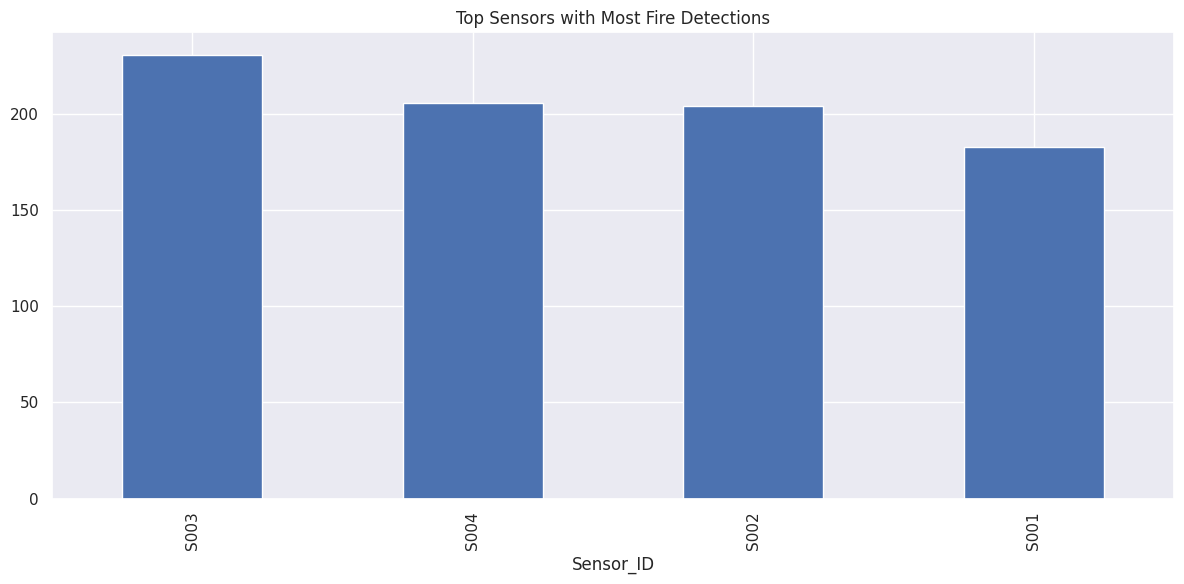

In [82]:
# 12. Sensor Performance Analysis
print("\n" + "="*50)
print("12. SENSOR PERFORMANCE ANALYSIS")
print("="*50)

fire_sensors = df[df['Fire_Status'] == 1]['Sensor_ID'].value_counts().head(10)
print("\nTop 10 Sensors with Most Fire Detections:")
print(fire_sensors)

plt.figure(figsize=(12, 6))
fire_sensors.plot(kind='bar')
plt.title('Top Sensors with Most Fire Detections')
plt.tight_layout()
plt.show()

In [83]:
# Fill numerical columns with mean
num_cols = ['Temperature', 'Humidity', 'Gas_Concentration']
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Fill categorical columns with mode
cat_cols = ['Sensor_ID', 'Event_Type', 'Alert_Level', 'Response_Actions', 'Location_ID']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill timestamp if needed (optional)
df['Timestamp'] = df['Timestamp'].fillna(method='ffill')

<ipython-input-83-2076508455>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Timestamp'] = df['Timestamp'].fillna(method='ffill')


In [84]:
print("\nMissing values after filling:")
print(df.isnull().sum())


Missing values after filling:
Timestamp            0
Date                 0
Sensor_ID            0
Temperature          0
Humidity             0
Gas_Concentration    0
Fire_Status          0
Event_Type           0
Alert_Level          0
Location_ID          0
Response_Actions     0
Incident_ID          0
Hour                 0
Day                  0
DayOfWeek            0
Sector               0
dtype: int64


In [85]:
# Drop unwanted columns
df.drop(['Location_ID', 'Response_Actions', 'Incident_ID'], axis=1, inplace=True)

In [86]:
# Feature Engineering: Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['hour'] = df['Timestamp'].dt.hour
df['dayofweek'] = df['Timestamp'].dt.dayofweek
df['minute'] = df['Timestamp'].dt.minute

In [87]:
# Drop original Timestamp and Date
df.drop(['Timestamp', 'Date'], axis=1, inplace=True)

In [88]:
# Encode categorical features
cat_cols = ['Sensor_ID', 'Fire_Status']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode y labels
y_labels = ['Event_Type', 'Alert_Level']
y_encoders = {}
for col in y_labels:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    y_encoders[col] = le

# Define features and targets
X = df.drop(columns=y_labels)
y = df[y_labels]

In [89]:
# Encode the 'Sector' column
from sklearn.preprocessing import LabelEncoder

sector_encoder = LabelEncoder()
X['Sector'] = sector_encoder.fit_transform(X['Sector'])

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [91]:
# Train-test split (last 10080 = 7 days * 1440 minutes)
X_train, X_test = X_scaled[:-10080], X_scaled[-10080:]
y_train, y_test = y[:-10080], y[-10080:]

In [92]:
# Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model = MultiOutputClassifier(xgb)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:05:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))

In [93]:
# Predict next 10080 minutes (simulate for each minute)
# For simplicity, we’ll just predict for the test set
y_pred = model.predict(X_test)

In [94]:
# Convert predictions to labels
y_pred_df = pd.DataFrame(y_pred, columns=y_labels)
for col in y_labels:
    y_pred_df[col] = y_encoders[col].inverse_transform(y_pred_df[col])

# Save predictions
#y_pred_df.to_csv("predicted_next_week_labels_final.csv", index=False)

print("Predictions saved as predicted_next_week_labels_final.csv")

Predictions saved as predicted_next_week_labels_final.csv


In [95]:
# --- Reconstruct Sensor_ID and Timestamp ---

# One week = 10080 mins, and 4 sensors = 40320 rows
num_sensors = 4
minutes_per_week = 10080

# Generate timestamps for one week starting from 00:00
start_time = pd.to_datetime("2025-06-08 00:00:00")  # Adjust the start date if needed
timestamps = [start_time + pd.Timedelta(minutes=i) for i in range(minutes_per_week)] * num_sensors

# Repeat Sensor_IDs for each week (S001 to S004)
sensor_ids = ['S001', 'S002', 'S003', 'S004']
sensor_id_series = [sid for sid in sensor_ids for _ in range(minutes_per_week)]

# Create DataFrame with Timestamp and Sensor_ID
meta_df = pd.DataFrame({
    'Timestamp': timestamps,
    'Sensor_ID': sensor_id_series
})

# --- Decode predictions ---
y_pred_df = pd.DataFrame(y_pred, columns=y_labels)
for col in y_labels:
    y_pred_df[col] = y_encoders[col].inverse_transform(y_pred_df[col])

# --- Combine and save ---
final_df = pd.concat([meta_df, y_pred_df], axis=1)
final_df.to_csv("predicted_next_week_labels_final.csv", index=False)

print("✅ Final CSV saved with Timestamp, Sensor_ID, Event_Type, and Alert_Level")


✅ Final CSV saved with Timestamp, Sensor_ID, Event_Type, and Alert_Level


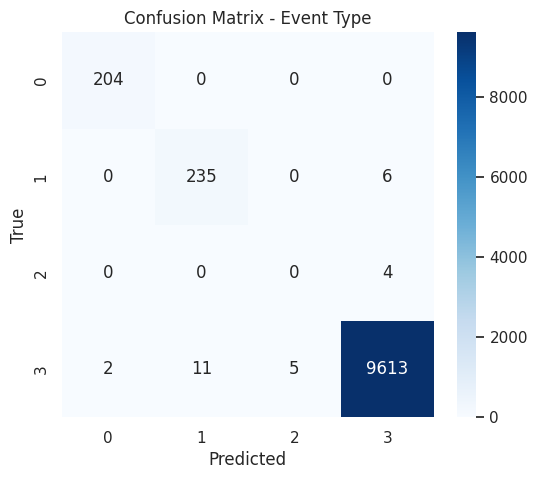

Classification Report for Event Type:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       204
           1       0.96      0.98      0.97       241
           2       0.00      0.00      0.00         4
           3       1.00      1.00      1.00      9631

    accuracy                           1.00     10080
   macro avg       0.74      0.74      0.74     10080
weighted avg       1.00      1.00      1.00     10080



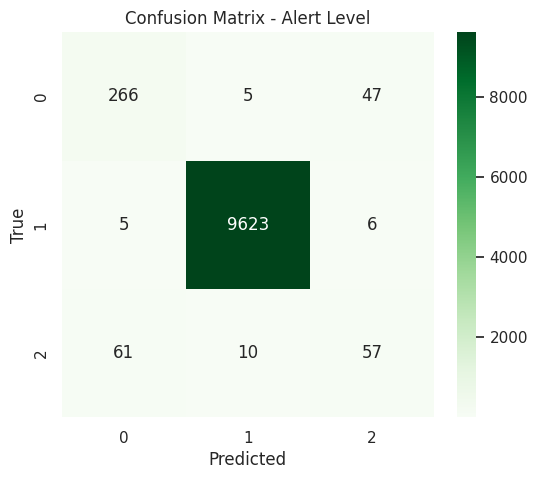

Classification Report for Alert Level:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       318
           1       1.00      1.00      1.00      9634
           2       0.52      0.45      0.48       128

    accuracy                           0.99     10080
   macro avg       0.77      0.76      0.77     10080
weighted avg       0.99      0.99      0.99     10080



In [97]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_test and y_pred to Series if needed
true_event = y_test['Event_Type']
pred_event = y_pred[:, 0]  # first column is Event_Type

true_alert = y_test['Alert_Level']
pred_alert = y_pred[:, 1]  # second column is Alert_Level

# EVENT TYPE CONFUSION MATRIX
cm_event = confusion_matrix(true_event, pred_event)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_event, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Event Type')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report for Event Type:")
print(classification_report(true_event, pred_event))

# ALERT LEVEL CONFUSION MATRIX
cm_alert = confusion_matrix(true_alert, pred_alert)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_alert, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Alert Level')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report for Alert Level:")
print(classification_report(true_alert, pred_alert))
